In [1]:
#Importing modules, tools, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols

#importing main dataframe as df
df = pd.read_csv('data/kc_house_data.csv')

12764    13540
7245     12050
3910     10040
9245      9890
8085      9640
         ...  
11488      420
8614       410
21316      390
860        380
15367      370
Name: sqft_living, Length: 21597, dtype: int64
4980.0


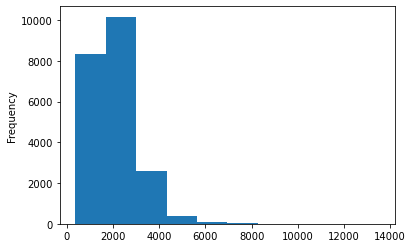

In [2]:
#Converting grade column to an int value

#Create a dummy list
grade_num = []

#Go through each row, grabbing the first index off the string, conver to int
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))

#drop the old column and add the new
df['grade_num'] = grade_num
df.drop('grade', axis = 1)

# Turning NaNs in the waterfront data into NO's, then converting waterfront to binary.
# 0 is a waterfront no, 1 is a waterfront yes
#

df.waterfront.fillna(value='NO', inplace = True)
df.waterfront.replace( to_replace = ['NO','YES'], value =  [0,1], inplace = True)

print(df['sqft_living'].sort_values(ascending = False))
#Those are some big results.
print(df['sqft_living'].quantile(0.99))
# even the 99 percentile is still sub 5000. 
df['sqft_living'].plot(kind = 'hist');
#Plotting this shows a bit skew right.


#It may be wise to shave the model off around there.

<AxesSubplot:ylabel='Frequency'>

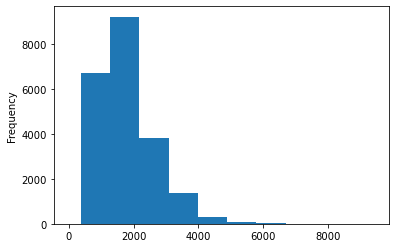

In [3]:
df['sqft_above'].sort_values(ascending = False) 
df['sqft_above'].quantile(.99)
#Not quite as extreme as sqft_livable

df['sqft_above'].plot(kind='hist');

df.sqft_living.describe()
df['sqft_living_ratio'] = df['sqft_living'] / df['sqft_living15']
df.sqft_living_ratio.describe()


df['sqft_living_ratio'] = df.sqft_living / df.sqft_living15
df['sqft_living_ratio'] = df['sqft_living_ratio'].loc[(np.abs(stats.zscore(df.sqft_living_ratio)) < 2)]
df = df.dropna(subset = ['sqft_living_ratio'])
df.sqft_living_ratio.plot.hist()

count    20386.000000
mean         1.042518
std          0.312278
min          0.054972
25%          0.933333
50%          1.000000
75%          1.077654
max          3.275862
Name: sqft_lot_ratio, dtype: float64

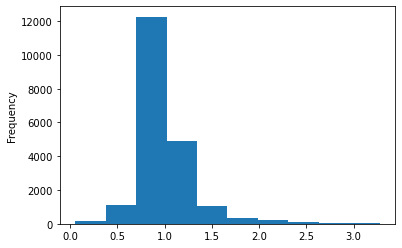

In [4]:
df.sqft_lot15.describe()
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']
df.sqft_lot_ratio.describe()

df['sqft_lot_ratio'] = df.sqft_lot / df.sqft_lot15
df['sqft_lot_ratio'] = df['sqft_lot_ratio'].loc[(np.abs(stats.zscore(df.sqft_lot_ratio)) < 2)]
df = df.dropna(subset = ['sqft_lot_ratio'])
df.sqft_lot_ratio.plot.hist()
df.sqft_lot_ratio.describe()

In [5]:
df = df[df['bedrooms'] < 33]

In [6]:
df['floors'].value_counts()
#Seems reasonable. Maybe make it categorical?


1.0    10240
2.0     7673
1.5     1757
3.0      575
2.5      134
3.5        6
Name: floors, dtype: int64

In [7]:
# Cleaning the basement data

df['sqft_basement'] = df['sqft_basement'].replace({'?': 0.0})
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [8]:
# Cleaning the view data
df['view'] = df['view'].replace({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'FAIR': 3, 'EXCELLENT':4})

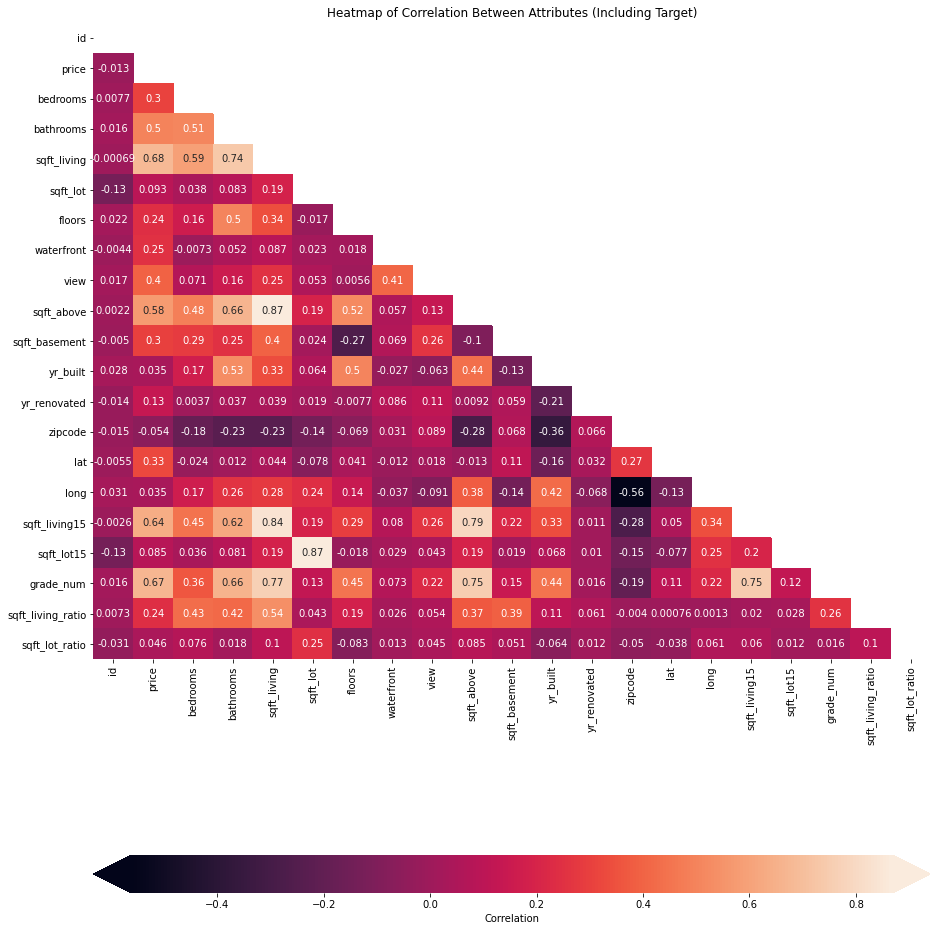

In [9]:
import seaborn as sns
import numpy as np

corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [21]:
X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront','zipcode', 'grade_num']]
y = df.price

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.dummy import DummyRegressor
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
print(f'Baseline Regression Score: {baseline.score(X_test, y_test)}')

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
print(f'Regression Score from training data: {linreg.score(X_train, y_train)}')
print(f'Regression Score from testing data: {linreg.score(X_test, y_test)}')
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

from sklearn.metrics import mean_squared_error

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate training and test MSE

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', np.sqrt(train_mse))
print('Test Root Mean Squarred Error:', np.sqrt(test_mse))

Baseline Regression Score: -0.00019751533468670424
Regression Score from training data: 0.5804555670432952
Regression Score from testing data: 0.549534345250728
Train Root Mean Squarred Error: 214230.22659825842
Test Root Mean Squarred Error: 219969.5328887058


In [11]:
from statsmodels.formula.api import ols
X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','sqft_living15', 'sqft_lot15', 'grade_num']]

In [13]:
formula = 'price~ bedrooms + bathrooms + sqft_living + sqft_lot + C(waterfront) + floors + C(zipcode) + grade_num'
regression = ols(formula, data = df).fit().summary()
regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1049.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:38:43   Log-Likelihood:            -2.7170e+05
No. Observations:               20385   AIC:                         5.436e+05
Df Residuals:                   20308   BIC:                         5.442e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4.246e+05   1.28e+04    -33.103      0.000    -4.5e+05   -3.99e+05
C(waterfront)[T.1]   8.061e+05   1.36e+04     59.305      0.000    7.79e+05    8.33e+05
C(zipcode)[T.98002]  4.639e+04   1.35e+04      3.425      0.001    1.98e+04    7.29e+04
C(zipcode)[T.98003] -9832.5214   1.21e+04     -0.815      0.415   -3.35e+04    1.38e+04
C(zipcode)[T.98004]  7.477e+05   1.21e+04     61.903      0.000    7.24e+05    7.71e+05
C(zipcode)[T.98005]  3.017e+05   1.43e+04     21.155      0.000    2.74e+05     3.3e+05
C(zipcode)[T.98006]  2.934e+05   1.06e+04     27.603      0.000    2.73e+05    3.14e+05
C(zipcode)[T.98007]  2.473e+05    1.5e+04     16.508      0.000    2.18e+05    2.77e+05
C(zipcode)[T.98008]  2.658e+05   1.21e+04     21.964      0.000    2.42e+05     2.9e+05
C(zipcode)[T.98010]  7.683e+04   1.76e+04      4.363      0.000    4.23e+04    1.11e+05
C(zipcode)[T.98011]  1.123e+05   1.35e+04      8.336      0.000    8.59e+04    1.39e+05
C(zipcode)[T.98014]  9.101e+04   1.65e+04      5.507      0.000    5.86e+04    1.23e+05
C(zipcode)[T.98019]  7.779e+04   1.37e+04      5.688      0.000     5.1e+04    1.05e+05
C(zipcode)[T.98022]  2.704e+04   1.31e+04      2.067      0.039    1396.772    5.27e+04
C(zipcode)[T.98023] -3.992e+04   1.05e+04     -3.817      0.000   -6.04e+04   -1.94e+04
C(zipcode)[T.98024]  1.418e+05   2.04e+04      6.933      0.000    1.02e+05    1.82e+05
C(zipcode)[T.98027]  1.606e+05    1.1e+04     14.594      0.000    1.39e+05    1.82e+05
C(zipcode)[T.98028]  1.179e+05   1.21e+04      9.742      0.000    9.42e+04    1.42e+05
C(zipcode)[T.98029]  2.029e+05   1.17e+04     17.394      0.000     1.8e+05    2.26e+05
C(zipcode)[T.98030]  -975.9818   1.24e+04     -0.079      0.937   -2.53e+04    2.34e+04
C(zipcode)[T.98031]  9010.6441   1.22e+04      0.738      0.460   -1.49e+04    3.29e+04
C(zipcode)[T.98032]  9666.5326   1.58e+04      0.612      0.540   -2.13e+04    4.06e+04
C(zipcode)[T.98033]  3.572e+05    1.1e+04     32.540      0.000    3.36e+05    3.79e+05
C(zipcode)[T.98034]      2e+05   1.03e+04     19.447      0.000     1.8e+05     2.2e+05
C(zipcode)[T.98038]  2.485e+04   1.02e+04      2.445      0.014    4928.701    4.48e+04
C(zipcode)[T.98039]  1.153e+06   2.44e+04     47.152      0.000     1.1e+06     1.2e+06
C(zipcode)[T.98040]  5.372e+05   1.23e+04     43.783      0.000    5.13e+05    5.61e+05
C(zipcode)[T.98042]  4400.7744   1.03e+04      0.426      0.670   -1.59e+04    2.47e+04
C(zipcode)[T.98045]  1.029e+05   1.33e+04      7.761      0.000    7.69e+04    1.29e+05
C(zipcode)[T.98052]  2.205e+05   1.02e+04     21.591      0.000       2e+05    2.41e+05
C(zipcode)[T.98053]  1.888e+05   1.11e+04     17.007      0.000    1.67e+05    2.11e+05
C(zipcode)[T.98055]  4.915e+04   1.23e+04      3.983      0.000     2.5e+04    7.33e+04
C(z

In [24]:
correlation = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)

correlation['pairs'] = list(zip(correlation.level_0,correlation.level_1))

correlation.set_index(['pairs'], inplace = True)

correlation.drop(columns=['level_0','level_1'], inplace= True)

correlation.columns = ['cc']

correlation.drop_duplicates(inplace = True)

correlation[(correlation.cc>.75) & (correlation.cc<1)]

,cc
pairs,
"(grade_num, sqft_living)",0.765411


In [26]:
# Run this cell without changes

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")


NameError: name 'splitter' is not defined